In [59]:
from numpy import array
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

# fixem random seed
np.random.seed(7)

dadesSau = read_csv('dadesSau.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 17
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

In [20]:

# Inicialitzem algoritme
regr_multirf = MultiOutputRegressor(SVR(kernel='rbf'))

n_steps_out = 15
propTrainTest = 0.8
c = np.arange(5,126,5)
epsilon = uniform.rvs(0.0001, 0.1, 50, random_state=4568)
gamma = uniform.rvs(0.01, 0.9, 50, random_state=4568)

params = {'estimator__C':c,
          'estimator__gamma':gamma,
          'estimator__epsilon':epsilon}

svr = SVR(kernel='rbf')
rand_search = RandomizedSearchCV(MultiOutputRegressor(svr),param_distributions = params, n_iter = 500, cv=TimeSeriesSplit(n_splits=4).get_n_splits([train_X,train_Y]), scoring='neg_mean_squared_error', random_state = 125, n_jobs=-1) 

# Apliquem dades d'entrenament
rand_search.fit(train_X, train_Y)

RandomizedSearchCV(cv=4, error_score='raise',
          estimator=MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1),
          fit_params=None, iid=True, n_iter=500, n_jobs=-1,
          param_distributions={'estimator__C': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125]), 'estimator__gamma': array([0.12305, 0.49427, 0.74765, 0.82007, 0.34299, 0.77757, 0.15946,
       0.40994, 0.77886, 0.68336...82, 0.04698,
       0.02186, 0.03246, 0.08896, 0.02593, 0.09272, 0.00827, 0.05515,
       0.09119])},
          pre_dispatch='2*n_jobs', random_state=125, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [21]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


report(rand_search.cv_results_)

Model with rank: 1
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.03123104842991658, 'estimator__epsilon': 0.016706236123561247, 'estimator__C': 35}

Model with rank: 2
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.03123104842991658, 'estimator__epsilon': 0.012661120647336443, 'estimator__C': 20}

Model with rank: 3
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.03123104842991658, 'estimator__epsilon': 0.03611095934986012, 'estimator__C': 25}

Model with rank: 4
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.03123104842991658, 'estimator__epsilon': 0.04251955715299158, 'estimator__C': 95}

Model with rank: 5
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.08349421867268642, 'estimator__epsilon': 0.032462332263000084, 'estimator__C': 5}

Model with rank: 6
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__gamma': 0.0

In [35]:
# Fit regression model
regr_multirf = MultiOutputRegressor(SVR(kernel='rbf', C=rand_search.best_params_['estimator__C'], gamma=rand_search.best_params_['estimator__gamma'], 
                                        epsilon=rand_search.best_params_['estimator__epsilon']))
regr_multirf.fit(train_X, train_Y)
# Predict on new data
testPredict = regr_multirf.predict(test_X)


In [36]:
test_YR = scaler.inverse_transform(test_Y)
testPredict = scaler.inverse_transform(testPredict)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.719270603826375


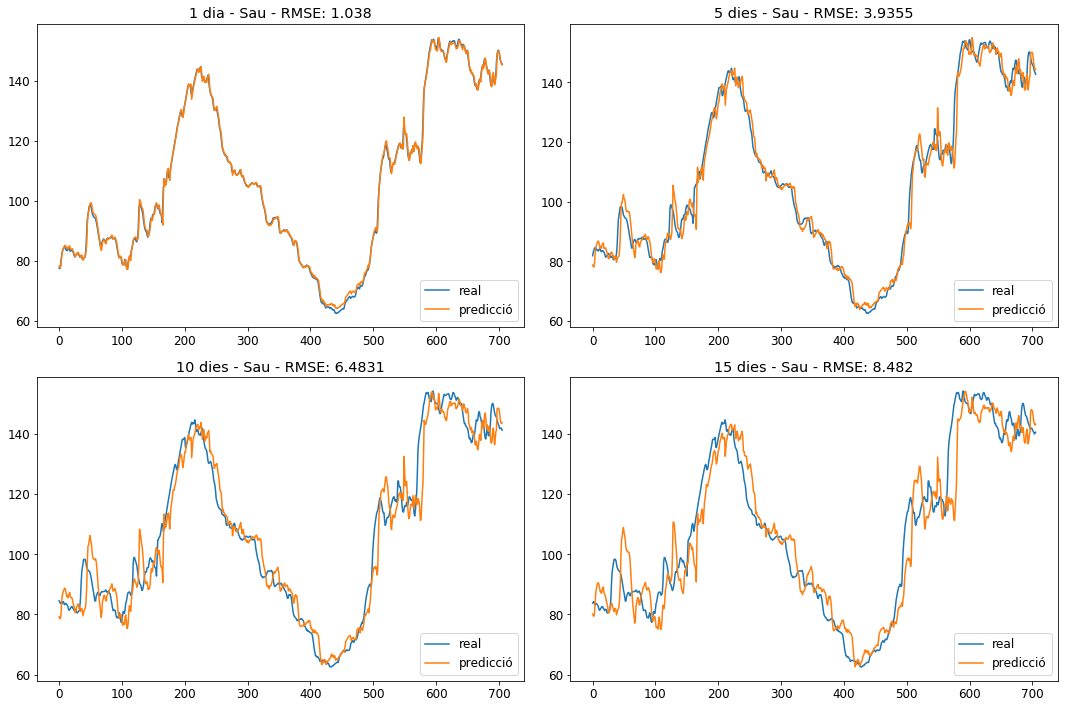

In [37]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],4))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],4))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],4))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],4))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [41]:
c = np.arange(25,46,2)
epsilon = np.arange(0.01, 0.021, 0.001)
gamma = np.arange(0.0225, 0.0356, 0.001)

params = {'estimator__C':c,
          'estimator__gamma':gamma,
          'estimator__epsilon':epsilon}

svr = SVR(kernel='rbf')

# Apliquem dades d'entrenament


grid_search = GridSearchCV(MultiOutputRegressor(svr), param_grid = params, 
                          cv=TimeSeriesSplit(n_splits=4).get_n_splits([train_X,train_Y]), 
                           scoring='neg_mean_squared_error', n_jobs = -1)

grid_search.fit(train_X, train_Y)

GridSearchCV(cv=4, error_score='raise',
       estimator=MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__C': array([25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]), 'estimator__gamma': array([0.0225, 0.0235, 0.0245, 0.0255, 0.0265, 0.0275, 0.0285, 0.0295,
       0.0305, 0.0315, 0.0325, 0.0335, 0.0345, 0.0355]), 'estimator__epsilon': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [42]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.011999999999999999, 'estimator__gamma': 0.0225}

Model with rank: 2
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.011, 'estimator__gamma': 0.0225}

Model with rank: 3
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.011, 'estimator__gamma': 0.0235}

Model with rank: 4
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.01, 'estimator__gamma': 0.0225}

Model with rank: 5
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.011999999999999999, 'estimator__gamma': 0.0235}

Model with rank: 6
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 45, 'estimator__epsilon': 0.012999999999999998, 'estimator__gamma': 0.0225}

Model with rank: 7
Mean validation sco

In [43]:
regr_multirf = MultiOutputRegressor(SVR(kernel='rbf', C=grid_search.best_params_['estimator__C'], gamma=grid_search.best_params_['estimator__gamma'], 
                                        epsilon=grid_search.best_params_['estimator__epsilon']))
regr_multirf.fit(train_X, train_Y)
# Predict on new data
testPredict = regr_multirf.predict(test_X)


In [44]:
test_YR = scaler.inverse_transform(test_Y)
testPredict = scaler.inverse_transform(testPredict)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.708975788263103


In [49]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.9580926786322317, 1.8181308528390745, 2.5853483641447017, 3.275100724181892, 3.9192832532802626, 4.488834968774554, 5.028391192478723, 5.546122479484645, 6.0338495975025745, 6.482600765853284, 6.89617449153893, 7.301758326806718, 7.708135550028612, 8.082765949127314, 8.464442855159842]
╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.958093 │ 1.81813 │ 2.58535 │  3.2751 │ 3.91928 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.48883 │ 5.02839 │ 5.54612 │ 6.03385 │   6.4826 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪═

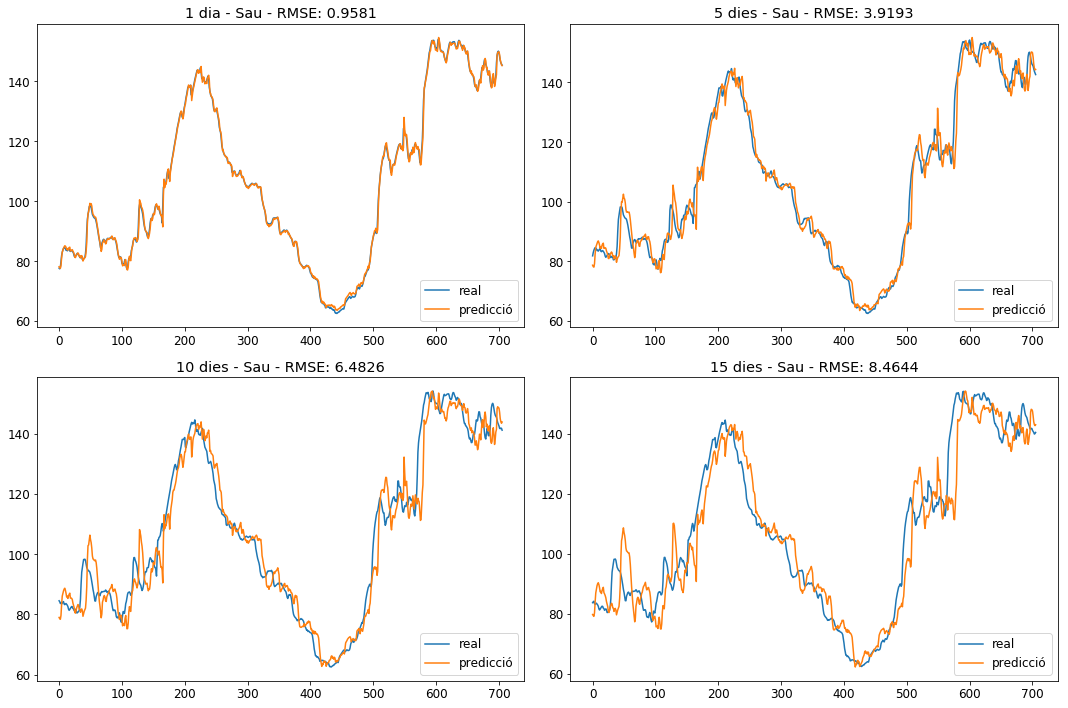

In [46]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],4))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],4))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],4))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],4))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

Prova d'optmitzar la definició de paràmetres que hem utiltizat d'entrada, per veure si donen millor resultat

In [48]:
c = np.arange(70,80,1)
epsilon = np.arange(0.002, 0.004, 0.0002)
gamma = np.arange(0.05, 0.16, 0.01)

params = {'estimator__C':c,
          'estimator__gamma':gamma,
          'estimator__epsilon':epsilon}

svr = SVR(kernel='rbf')

# Apliquem dades d'entrenament


grid_search = GridSearchCV(MultiOutputRegressor(svr), param_grid = params, 
                          cv=TimeSeriesSplit(n_splits=4).get_n_splits([train_X,train_Y]), 
                           scoring='neg_mean_squared_error', n_jobs = -1)

grid_search.fit(train_X, train_Y)

GridSearchCV(cv=4, error_score='raise',
       estimator=MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__C': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), 'estimator__gamma': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15]), 'estimator__epsilon': array([0.002 , 0.0022, 0.0024, 0.0026, 0.0028, 0.003 , 0.0032, 0.0034,
       0.0036, 0.0038])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 71, 'estimator__epsilon': 0.0030000000000000005, 'estimator__gamma': 0.05}

Model with rank: 2
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 70, 'estimator__epsilon': 0.0030000000000000005, 'estimator__gamma': 0.05}

Model with rank: 3
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 70, 'estimator__epsilon': 0.0028000000000000004, 'estimator__gamma': 0.05}

Model with rank: 4
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 70, 'estimator__epsilon': 0.0032000000000000006, 'estimator__gamma': 0.05}

Model with rank: 5
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 70, 'estimator__epsilon': 0.0034000000000000007, 'estimator__gamma': 0.05}

Model with rank: 6
Mean validation score: -0.004 (std: 0.001)
Parameters: {'estimator__C': 71, 'estimator__epsilon': 0.0032000000000000006, 'estimator__gamma': 0.05}

In [61]:
regr_multirf2 = MultiOutputRegressor(SVR(kernel='rbf', C=grid_search.best_params_['estimator__C'], gamma=grid_search.best_params_['estimator__gamma'], 
                                        epsilon=grid_search.best_params_['estimator__epsilon']))
regr_multirf2.fit(train_X, train_Y)
# Predict on new data
testPredict2 = regr_multirf2.predict(test_X)

In [63]:
test_YR = scaler.inverse_transform(test_Y)
testPredict = scaler.inverse_transform(testPredict2)


RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.6961141122221015


In [64]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.8726660171590043, 1.7814917243515607, 2.5470592310717293, 3.2487295488723786, 3.897898654916611, 4.480914054927956, 5.024941224121579, 5.535722291260292, 6.028050945221349, 6.478108475772383, 6.8969771478691815, 7.296093616078979, 7.68965370633855, 8.06766598830811, 8.439176155373373]
╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.872666 │ 1.78149 │ 2.54706 │ 3.24873 │  3.8979 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.48091 │ 5.02494 │ 5.53572 │ 6.02805 │  6.47811 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══

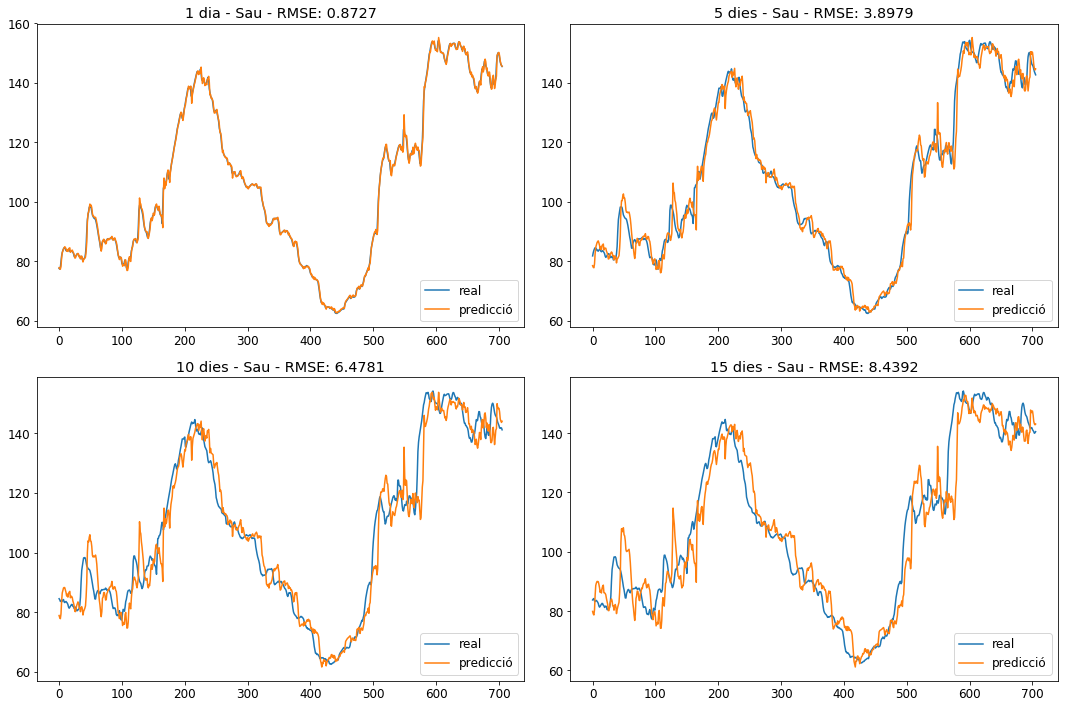

In [65]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],4))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],4))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],4))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],4))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()